<a href="https://colab.research.google.com/github/Jeffateth/AllergenPredict/blob/main/Decode_EMS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ Step 1: Install and Load ESM-2

In [1]:
!pip install fair-esm

In [2]:
import torch
import esm

# Load ESM-2 model (smallest version for demonstration; use larger one if you have GPU resources)
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

# Put model in eval mode (or .train() later if you plan to fine-tune)
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=120, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((320,), eps=1e-05, elementwis

# ✅ Step 2: Define Attention Pooling and Classifier

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class AttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attn = nn.Linear(embed_dim, 1)

    def forward(self, token_embeddings, attention_mask):
        # token_embeddings: (batch_size, seq_len, embed_dim)
        # attention_mask: (batch_size, seq_len), 1 = real token, 0 = padding
        scores = self.attn(token_embeddings).squeeze(-1)  # (batch_size, seq_len)
        scores = scores.masked_fill(attention_mask == 0, float('-inf'))  # mask padding
        attn_weights = F.softmax(scores, dim=-1)  # (batch_size, seq_len)
        weighted_sum = torch.sum(token_embeddings * attn_weights.unsqueeze(-1), dim=1)  # (batch_size, embed_dim)
        return weighted_sum, attn_weights  # also return weights for interpretability


## ✅ Classifier using AttentionPooling

In [4]:
class ProteinClassifier(nn.Module):
    def __init__(self, esm_model, embed_dim, num_classes=2):
        super().__init__()
        self.esm_model = esm_model  # frozen or fine-tuned
        self.pooling = AttentionPooling(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, tokens, attention_mask):
        with torch.no_grad():  # optional: freeze ESM-2
            results = self.esm_model(tokens, repr_layers=[6])  # use last layer for esm2_t6_8M_UR50D
            token_reps = results["representations"][6]  # (batch_size, seq_len, embed_dim)

        pooled, attn_weights = self.pooling(token_reps, attention_mask)
        logits = self.classifier(pooled)
        return logits, attn_weights



# ✅ Step 3: Preprocessing Sequences and Creating Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader

class ProteinSequenceDataset(Dataset):
    def __init__(self, sequences, labels, batch_converter, max_length=1022):
        self.sequences = sequences
        self.labels = labels
        self.batch_converter = batch_converter
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        label = self.labels[idx]
        sequence = self.sequences[idx]
        sequence = sequence[:self.max_length]  # truncate if too long
        return (f"protein_{idx}", sequence), label

def collate_fn(batch):
    batch_data, batch_labels = zip(*batch)
    labels = torch.tensor(batch_labels, dtype=torch.long)
    _, _, tokens = batch_converter(batch_data)  # ESM batch converter handles padding
    attention_mask = (tokens != alphabet.padding_idx).long()  # mask: 1=real, 0=pad
    return tokens, attention_mask, labels


## ✅ Step 3.2: Load Data for Training

In [6]:
import pandas as pd

# Load data
train_df = pd.read_csv("algpred2_train.csv")
test_df = pd.read_csv("algpred2_test.csv")

# Extract sequences and labels
train_sequences = train_df["sequence"].tolist()
train_labels = train_df["label"].tolist()

test_sequences = test_df["sequence"].tolist()
test_labels = test_df["label"].tolist()

## ✅ Step 3.3: Create PyTorch Dataloaders

In [7]:
# Train and test datasets
train_dataset = ProteinSequenceDataset(train_sequences, train_labels, batch_converter)
test_dataset = ProteinSequenceDataset(test_sequences, test_labels, batch_converter)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# ✅ Step 4.1: Initialize the Model

In [8]:
# Define model
embed_dim = 320  # for esm2_t6_8M_UR50D
model = ProteinClassifier(esm_model=model, embed_dim=embed_dim, num_classes=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ProteinClassifier(
  (esm_model): ESM2(
    (embed_tokens): Embedding(33, 320, padding_idx=1)
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=320, out_features=320, bias=True)
          (v_proj): Linear(in_features=320, out_features=320, bias=True)
          (q_proj): Linear(in_features=320, out_features=320, bias=True)
          (out_proj): Linear(in_features=320, out_features=320, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=320, out_features=1280, bias=True)
        (fc2): Linear(in_features=1280, out_features=320, bias=True)
        (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
    )
    (contact_head): ContactPredictionHead(
      (regression): Linear(in_features=120, out_features=1, bias=True)
      (activation): Sigmoid

## ✅ Step 4.2: Define Loss and Optimizer

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


## ✅ Step 4.3: Training Loop

In [10]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for tokens, attention_mask, labels in dataloader:
        tokens, attention_mask, labels = tokens.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(tokens, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


### ✅ Step 4.4: Training Over Epochs

In [11]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Epoch 1/5, Loss: 0.4166
Epoch 2/5, Loss: 0.2615
Epoch 3/5, Loss: 0.2239
Epoch 4/5, Loss: 0.2020
Epoch 5/5, Loss: 0.1851


# ✅ Step 5.1: Get Predictions & Attention Scores

In [14]:
def evaluate_with_attention(model, dataloader, device, alphabet):
    model.eval()
    results = []

    with torch.no_grad():
        for tokens, attention_mask, labels in dataloader:
            tokens = tokens.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits, attn_weights = model(tokens, attention_mask)
            preds = torch.argmax(logits, dim=1)

            # Convert to CPU for processing
            for i in range(tokens.size(0)):
                token_ids = tokens[i].cpu().numpy()
                sequence = "".join([alphabet.get_tok(idx) for idx in token_ids if idx != alphabet.padding_idx])
                attention = attn_weights[i][:len(sequence)]  # Trim to real length
                label = labels[i].item()
                pred = preds[i].item()

                results.append((sequence, attention.cpu().numpy(), label, pred))

    return results


## ✅ Step 5.2: Visualize Residue-Level Attention (Heatmap)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention(sequence, attention_weights, title=None):
    plt.figure(figsize=(min(len(sequence)*0.25, 20), 2))
    sns.heatmap(np.expand_dims(attention_weights, axis=0),
                cmap='viridis',
                xticklabels=list(sequence),
                yticklabels=[],
                cbar=True)
    plt.title(title or "Residue Attention")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


## ✅ Step 5.3: Run and Plot for Sample

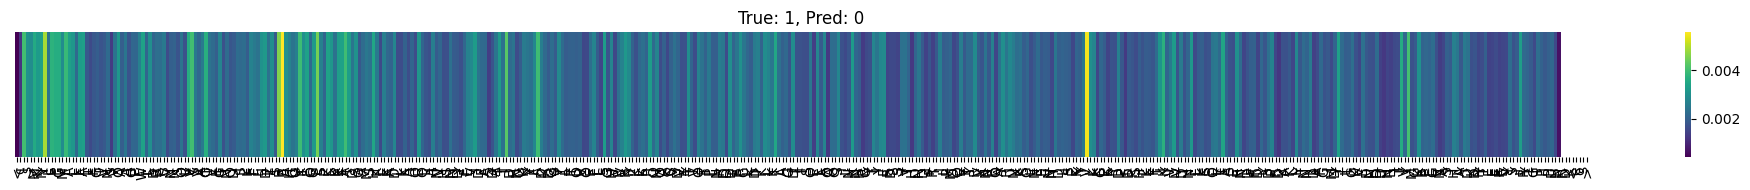

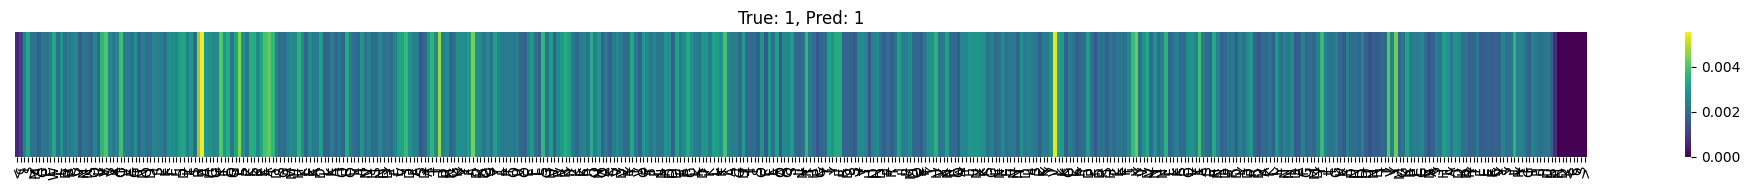

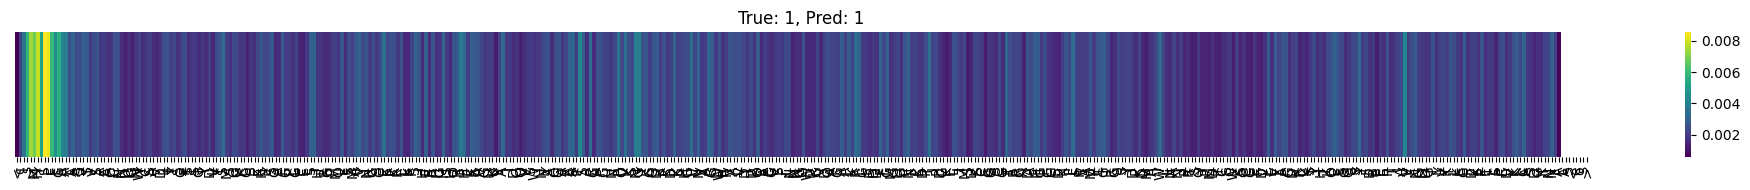

In [15]:
# Run evaluation and get attention scores
results = evaluate_with_attention(model, test_loader, device, alphabet)

# Plot the first 3 samples
for i in range(3):
    sequence, attention, label, pred = results[i]
    plot_attention(sequence, attention, title=f"True: {label}, Pred: {pred}")


## ✅ Improved Visualizations for Attention Weights

### ✅ Option 1: Bar Plot with Top-k Most Attended Residues

In [17]:
# Show only the top-k residues with highest attention
import numpy as np
import matplotlib.pyplot as plt

def plot_topk_attention(sequence, attention_weights, k=10, title=None):
    topk_indices = np.argsort(attention_weights)[-k:][::-1]
    topk_values = attention_weights[topk_indices]
    topk_residues = [sequence[i] + f"({i})" for i in topk_indices]

    plt.figure(figsize=(10, 4))
    plt.bar(topk_residues, topk_values, color="darkcyan")
    plt.title(title or f"Top-{k} Attention Residues")
    plt.ylabel("Attention weight")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


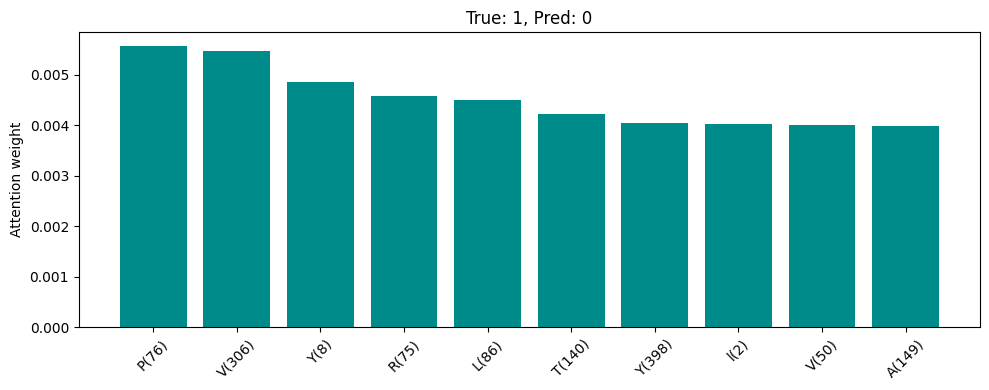

In [18]:
sequence, attention, label, pred = results[0]
plot_topk_attention(sequence, attention, k=10, title=f"True: {label}, Pred: {pred}")